## Download dataset

In [45]:
from google.colab import files

In [46]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"favourukasoanya","key":"3f7542650efacdb4e7fc870cef5a8ee6"}'}

In [47]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Aug  3 11:53 kaggle.json


In [48]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!pwd

/content


In [49]:
!chmod 600 ~/.kaggle/kaggle.json

In [50]:
!kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           7272        264  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Prediction Dataset    5MB  2023-07-03 12:12:19           7410        270  1.0              
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41           8762        158  1.0              
joebeachcapital/top-10000-spotify-songs-1960-now            Top 10000 Songs on Spotify 1960-Now

In [51]:
# Download Kaggle Dataset LFW-People (Face Recognition)
!kaggle datasets download -d atulanandjha/lfwpeople

lfwpeople.zip: Skipping, found more recently modified local copy (use --force to force download)


## Prep the Data

In [52]:
import numpy as np
import os
from pathlib import Path
from zipfile import ZipFile
import tarfile

### Extract the Data

In [53]:
file_path = '/content/lfwpeople.zip'
with ZipFile(file_path, 'r') as f:
  f.extractall('/content/lfwpeople')

In [54]:
file_path = '/content/lfwpeople/lfw-funneled.tgz'
with tarfile.open(file_path, 'r') as f:
  f.extractall('/content/lfwpeople/lfw-funneled')

In [55]:
data_dir = '/content/lfwpeople/lfw-funneled/lfw_funneled'
len(os.listdir(data_dir))

5760

### Create a Dataloader

In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [57]:
data_path = Path(data_dir)

X_dir = sorted([str(data_path / p / sorted(os.listdir(data_path / p))[0]) for p in os.listdir(data_path) if not os.path.isfile(data_path / p) and len(os.listdir(data_path / p)) > 1])
X1_dataset = tf.data.Dataset.from_tensor_slices(X_dir)
X2_dataset = tf.data.Dataset.list_files(data_dir + '/*/*0002.jpg', shuffle=False)
dataset = tf.data.Dataset.zip((X1_dataset, X2_dataset)).shuffle(1024)

In [58]:
len_data = len(X1_dataset)
print(len_data)

1680


In [59]:
def label_image(path):
  return tf.strings.split(path, os.path.sep)[-2] #path.split('/')[-2]

In [60]:

def process(path):
  label = label_image(path)
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # img = tf.image.convert_image_dtype(img, tf.float32)
  img = img/255
  img = tf.image.resize(img, (250, 250))

  return img, label

In [61]:
def process_pair(X1_path, X2_path):
  # we don't need the label in our workflow, but its good to know we have them.

  x1_img, x2_label = process(X1_path)
  x2_img, x2_label = process(X2_path)

  return x1_img, x2_img

In [62]:
dataset = dataset.map(process_pair)

In [63]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None))>

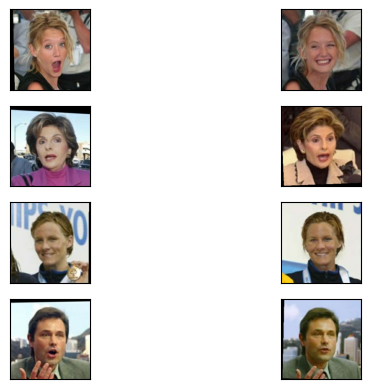

In [64]:
## Test it out (run this block multiple times to see multiple combinations)

fig, axes = plt.subplots(4, 2)

for (x1_img, x2_img), ax in zip(dataset.shuffle(200).take(4).as_numpy_iterator(), axes):
  # print('X1: ', x1_img.dtype)
  # print('X2: ', x2_img.dtype)
  ax[0].get_xaxis().set_visible(False)
  ax[0].get_yaxis().set_visible(False)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  ax[0].imshow(x1_img)
  ax[1].imshow(x2_img)


In [65]:
# Using tf.data.Dataset with functional keras model API requires that we account for labels.
# Although we dont need labels in our workflow, we will add redundant values

redundant_list = [0,] * len_data
redundant_data = tf.data.Dataset.from_tensor_slices(redundant_list)
# dataset = tf.data.Dataset.zip((dataset, redundant_data)).shuffle(1024)

In [66]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None))>

In [67]:
# Let's split into train/validation set
train_size = 0.7
dataset_size = len(dataset)
train_dataset = dataset.take(int(train_size * dataset_size))
validation_dataset = dataset.skip(int(train_size * dataset_size))

## Now let's render the data in batches of size 32 per batch
train_dataset = train_dataset.batch(32, drop_remainder=False).prefetch(8)
validation_dataset = validation_dataset.batch(32, drop_remainder=False).prefetch(8)

In [68]:
# Let's confirm the data_generator

for data in train_dataset.take(1).as_numpy_iterator():
  print(len(data[0][0]), len(data[0][1]))

250 250


## The Model

In [69]:
# Import dependacies

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.applications import resnet

### Build embeddings model

In [70]:
def embedding_model(input_shape):
  base_model = resnet.ResNet50(weights="imagenet", input_shape=input_shape, include_top=False)

  flatten = layers.Flatten()(base_model.output)
  dense1 = layers.Dense(512)(flatten)
  dense1 = layers.LeakyReLU()(dense1)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256)(dense1)
  dense2 = layers.LeakyReLU()(dense2)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256, activation="relu")(dense2)

  embedding = Model(base_model.input, output, name="Embedding")

  trainable = False
  for layer in base_model.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

  return embedding


In [71]:
input_shape = (250, 250, 3)
embedding = embedding_model(input_shape)

### Using The Functional API

In [72]:
class SimilarityLayer(layers.Layer):
  """
  layer to evaluate the cosine similarity between two vectors
  """
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, vec_1, vec_2):
    similarity = tf.reduce_sum(tf.square(vec_1 - vec_2), -1)
    return similarity


In [73]:
input_1 = layers.Input(name='input_1', shape=input_shape)#, dtype=tf.float32)
input_2 = layers.Input(name='input_2', shape=input_shape)#, dtype=tf.float32)

tower_1 = embedding(resnet.preprocess_input(input_1))
tower_2 = embedding(resnet.preprocess_input(input_2))

# for training
siamese_learn = Model(inputs=[input_1, input_2], outputs=[tower_1, tower_2])

# the complete model with the final similarity layer
similarity = SimilarityLayer()(tower_1, tower_2)
siamese_model = Model(inputs=[input_1, input_2], outputs=similarity)

In [74]:
# The cost function

def triplet_loss_fn(redundant, X, margin):
    # take a dot product (cosine similarity) of the embedding vectors to get a matrix
    # the diagonals represent duplicate vectors
    # calculate the mean negative (mean of all off-diagonal values in each row)
    # identify the closest negative (off diagonal value closest too but less than the
    #                                diagonal for each row)

    # L1 = max(mean_neg - s(A,P) + margin, 0)
    # L2 = max(closest_neg - s(A,P) + margin, 0)
    # Loss = L1 + L2

    X1 = X[0]
    X2 = X[1]

    batch_size = len(X1)

    print(X1, X1.dtype)
    print(X2, X2.dtype)
    # print(X2[0], X2[0].dtype)
    # print(X2[1], X2[1].dtype)

    # X1 = tf.cast(X1, tf.float32)
    # X2 = tf.cast(X2, tf.float32)

    # scores = tf.tensordot(X1, X2, 1)
    scores = tf.reduce_sum(tf.multiply(X1, X2), axis=0)

    print(scores)

    positives = tf.linalg.diag_part(scores)

    scores_without_positives = scores * (1 - tf.eye(batch_size))

    mean_negatives = tf.math.reduce_sum(scores_without_positives, axis=1) / (batch_size - 1)

    scores_minimize_positives = scores - 2 * tf.eye(batch_size)

    closest_negatives = tf.math.reduce_max(scores_minimize_positives, axis=1)

    triplet_loss_1 = tf.math.maximum(mean_negatives - positives + margin, 0)

    triplet_loss_2 = tf.math.maximum(closest_negatives - positives + margin, 0)

    triplet_loss = tf.math.reduce_mean(triplet_loss_1 + triplet_loss_2)

    return triplet_loss

In [75]:
from functools import partial

def TripletLoss(margin=0.5):
  loss_fn = partial(triplet_loss_fn, margin=margin)
  return loss_fn

In [76]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

In [77]:
# siamese_learn.compile(loss=TripletLoss(), optimizer=optimizers.Adam(0.0001))
# history = siamese_learn.fit(train_dataset, epochs=10, validation_data=validation_dataset)

In [78]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

### The Model Class

In [81]:
class Siamese(Model):
  def __init__(self, embedding_model, margin=0.5):
    super().__init__()
    self.embedding_model = embedding_model
    self.margin = margin
    self.loss_tracker = metrics.Mean(name="loss")

  def call(self, inputs):
    print("Prprprprprprprpr...")
    return self.embedding_model(inputs)

  def train_step(self, data):
    # GradientTape is a context manager that records every operation that
    # you do inside. We are using it here to compute the loss so we can get
    # the gradients and apply them using the optimizer specified in
    # `compile()`.
    with tf.GradientTape() as tape:
        loss = self._compute_loss(data)

    # Storing the gradients of the loss function with respect to the
    # weights/parameters.
    gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

    # Applying the gradients on the model using the specified optimizer
    self.optimizer.apply_gradients(
        zip(gradients, self.siamese_network.trainable_weights)
    )

    # Let's update and return the training loss metric.
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  def test_step(self, data):
    loss = self._compute_loss(data)

    # Let's update and return the loss metric.
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  def _compute_loss(self, data):
    # take a dot product (cosine similarity) of the embedding vectors to get a matrix
    # the diagonals represent duplicate vectors
    # calculate the mean negative (mean of all off-diagonal values in each row)
    # identify the closest negative (off diagonal value closest too but less than the
    #                                diagonal for each row)

    # L1 = max(mean_neg - s(A,P) + margin, 0)
    # L2 = max(closest_neg - s(A,P) + margin, 0)
    # Loss = L1 + L2

    print("calculating cost")
    batch_size = len(data)

    X1, X2 = self.embedding_model(data)

    print(X1.shape, X2.dtype, batch_size)

    scores = tf.reduce_sum(tf.multiply(X1, X2), axis=0)

    positives = tf.linalg.diag_part(scores)

    scores_without_positives = scores * (1 - tf.eye(batch_size))

    mean_negatives = tf.math.reduce_sum(scores_without_positives, axis=1) / (batch_size - 1)

    scores_minimize_positives = scores - 2 * tf.eye(batch_size)

    closest_negatives = tf.math.reduce_max(scores_minimize_positives, axis=1)

    triplet_loss_1 = tf.math.maximum(mean_negatives - positives + self.margin, 0)

    triplet_loss_2 = tf.math.maximum(closest_negatives - positives + self.margin, 0)

    triplet_loss = tf.math.reduce_mean(triplet_loss_1 + triplet_loss_2)

    self.loss_tracker.update_state(triplet_loss)
    return triplet_loss

  @property
  def metrics(self):
      # We need to list our metrics here so the `reset_states()` can be
      # called automatically.
      return [self.loss_tracker]


In [82]:
siamese_model = Siamese(siamese_learn)

siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
Prprprprprprprpr...


ValueError: ignored

In [ ]:
base_model.summary()